In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import math
import itertools
from IPython.display import clear_output
import numpy as np

%matplotlib inline 
#plt.set_cmap(cm.get_cmap("Spectral_r"))

Transposing cartesian coordinates to latitude / longitude 

https://math.stackexchange.com/questions/296794/finding-the-transform-matrix-from-4-projected-points-with-javascript/339033#339033


| var | cartesian | GPS |
|-----|-----------|-------------------------|
| x1  | (0,0)     | (40.750885, -73.998169) |
| x2  | (0,28)    | (40.768575, -73.985212) |
| x3  | (10,0)    | (40.743195, -73.979931) |
| x4  | (10,28)   | (40.760918, -73.966995) |


Below are just helpful calculations for getting the final combined matrix that transforms from source to destination

In [2]:
xC1 = (0,0)
xC2 = (0,28)
xC3 = (10,0)
xC4 = (10,28)

xLL1 = (40.750885, -73.998169)
xLL2 = (40.768575, -73.985212)
xLL3 = (40.743195, -73.979931)
xLL4 = (40.760918, -73.966995)

m_AC = np.mat([[xC1[0], xC2[0], xC3[0]], [xC1[1], xC2[1], xC3[1]], [1, 1, 1]])
m_BC = np.array(list(xC4) + [1]).reshape(-1,1)
lambda_C = np.matmul(np.linalg.inv(m_AC), m_BC)
lambda_C_ext = np.repeat(np.transpose(lambda_C), repeats=3,axis=0)
transform_C =  np.multiply(lambda_C_ext, m_AC)

m_ALL = np.mat([[xLL1[0], xLL2[0], xLL3[0]], [xLL1[1], xLL2[1], xLL3[1]], [1, 1, 1]])
m_BLL = np.array(list(xLL4) + [1]).reshape(-1,1)
lambda_LL = np.matmul(np.linalg.inv(m_ALL), m_BLL)
lambda_LL_ext = np.repeat(np.transpose(lambda_LL), repeats=3,axis=0)
transform_LL =  np.multiply(lambda_LL_ext, m_ALL)

fullmap = transform_LL * np.linalg.inv(transform_C)

def get_gps_coords(x, y):
    m_coords = np.transpose(np.mat([x, y, 1]))
    m_output = np.matmul(fullmap, m_coords)
    lat = np.around(m_output[0,0] / m_output[2,0], decimals=6)
    long = np.around(m_output[1,0] / m_output[2,0], decimals=6)
    return (lat, long)

#TEST
tests = [get_gps_coords(*xC1) == xLL1,
get_gps_coords(*xC2) == xLL2,
get_gps_coords(*xC3) == xLL3,
get_gps_coords(*xC4) == xLL4]

print(all(tests))

True


In [3]:
cart_Xs = [0, 2, 4, 6, 7, 8, 9, 10]
name_Xs = dict(zip(cart_Xs, ["9","8","7","6","5","Madison","Park","Lexington","3"]))
cart_Ys = list(range(0,29))
name_Ys = dict(zip(cart_Ys, [str(i+30) for i in cart_Ys]))

In [6]:
DG = nx.DiGraph()
coords = list(itertools.product(cart_Xs,cart_Ys))
for nodeid, pair in enumerate(coords):
    intersection = name_Xs[pair[0]] + "_" +  name_Ys[pair[1]]
    gps = get_gps_coords(*pair)
    DG.add_node(nodeid, cartesian=pair, name = intersection, latitude = gps[0], longitude = gps[1], nodetype="inner", color="#e1e3f0")

nodes = {v: k for k, v in nx.get_node_attributes(DG, "cartesian").items()}

for pair in nodes:
    
    nextave = cart_Xs.index(pair[0])+1
    if nextave >= len(cart_Xs):
        right = (-1,-1)
    else:
        right = (cart_Xs[nextave] , pair[1])
    above = (pair[0], pair[1] + 1)

    eastboundst = (pair[1] % 2) == 0   
    
    if above in nodes:#  and pair[0] not in {1,6}:
        
        if pair[0] in [2, 6, 8, 10]:
            DG.add_edge(nodes[pair], nodes[above], direction='north', lanes = 4, name = name_Xs[pair[0]] + "_ave")
        elif pair[0] == 9:
            DG.add_edge(nodes[pair], nodes[above], direction='north', lanes = 2, name = name_Xs[pair[0]] + "_ave")
            DG.add_edge(nodes[above], nodes[pair], direction='south', lanes = 2, name = name_Xs[pair[0]] + "_ave")
        else:
            DG.add_edge(nodes[above], nodes[pair], direction='south', lanes = 4, name = name_Xs[pair[0]] + "_ave")
            
    if right in nodes: # and pair[1] not in {1,6}:
        if pair[1] in [4, 12, 27]:
            DG.add_edge(nodes[pair], nodes[right], direction='east', lanes = 2, name = name_Ys[pair[1]] + "_st")
            DG.add_edge(nodes[right], nodes[pair], direction='west', lanes = 2, name = name_Ys[pair[1]] + "_st")
        if eastboundst:
            DG.add_edge(nodes[pair], nodes[right], direction='east', lanes = 2, name = name_Ys[pair[1]] + "_st")
        else:
            DG.add_edge(nodes[right], nodes[pair], direction='west', lanes = 2, name = name_Ys[pair[1]] + "_st")
            

for node in DG.nodes:
    border_west = DG.nodes[node]["cartesian"][0] == 0
    border_east = DG.nodes[node]["cartesian"][0] == 10
    
    border_north = DG.nodes[node]["cartesian"][1] == 0
    border_south = DG.nodes[node]["cartesian"][1] == 28
    
    border = (border_west or border_east or border_north or border_south)
    
    if DG.nodes[node]["cartesian"][0] == 0: # west border
        if DG.nodes[node]["cartesian"][1] in [4, 12, 27]:
            DG.nodes[node]["nodetype"] = "source_sink"
            DG.nodes[node]["color"] = "yellow"
        elif len([i for i in DG.out_edges(node) if DG.edges[i]['direction'] == 'east']) > 0:
            DG.nodes[node]["nodetype"] = "source"
            DG.nodes[node]["color"] = "green"
        else:
            DG.nodes[node]["nodetype"] = "sink"
            DG.nodes[node]["color"] = "red"
    elif DG.nodes[node]["cartesian"][0] == 10: # east border
        if DG.nodes[node]["cartesian"][1] in [4, 12, 27]:
            DG.nodes[node]["nodetype"] = "source_sink"
            DG.nodes[node]["color"] = "yellow"
        elif len([i for i in DG.out_edges(node) if DG.edges[i]['direction'] == 'west']) > 0:
            DG.nodes[node]["nodetype"] = "source"
            DG.nodes[node]["color"] = "green"
        else:
            DG.nodes[node]["nodetype"] = "sink"
            DG.nodes[node]["color"] = "red"
    elif DG.nodes[node]["cartesian"][1] == 28: # north border
        if DG.nodes[node]["cartesian"][0] == 9:
            DG.nodes[node]["nodetype"] = "source_sink"
            DG.nodes[node]["color"] = "yellow"
        elif len([i for i in DG.out_edges(node) if DG.edges[i]['direction'] == 'south']) > 0:
            DG.nodes[node]["nodetype"] = "source"
            DG.nodes[node]["color"] = "green"
        else:
            DG.nodes[node]["nodetype"] = "sink"
            DG.nodes[node]["color"] = "red"                
    elif DG.nodes[node]["cartesian"][1] == 0: # south border
        if DG.nodes[node]["cartesian"][0] == 9:
            DG.nodes[node]["nodetype"] = "source_sink"
            DG.nodes[node]["color"] = "yellow"
        elif len([i for i in DG.out_edges(node) if DG.edges[i]['direction'] == 'north']) > 0:
            DG.nodes[node]["nodetype"] = "source"
            DG.nodes[node]["color"] = "green"
        else:
            DG.nodes[node]["nodetype"] = "sink"
            DG.nodes[node]["color"] = "red"        
    
    
    #if border:
     #   print(DG.nodes[node]["name"])
        #DG.nodes[node]["nodetype"] = "source"
        #DG.nodes[node]["color"] = "green"
#     elif border:
#         DG.nodes[node]["nodetype"] = "sink"
#         DG.nodes[node]["color"] = "red"

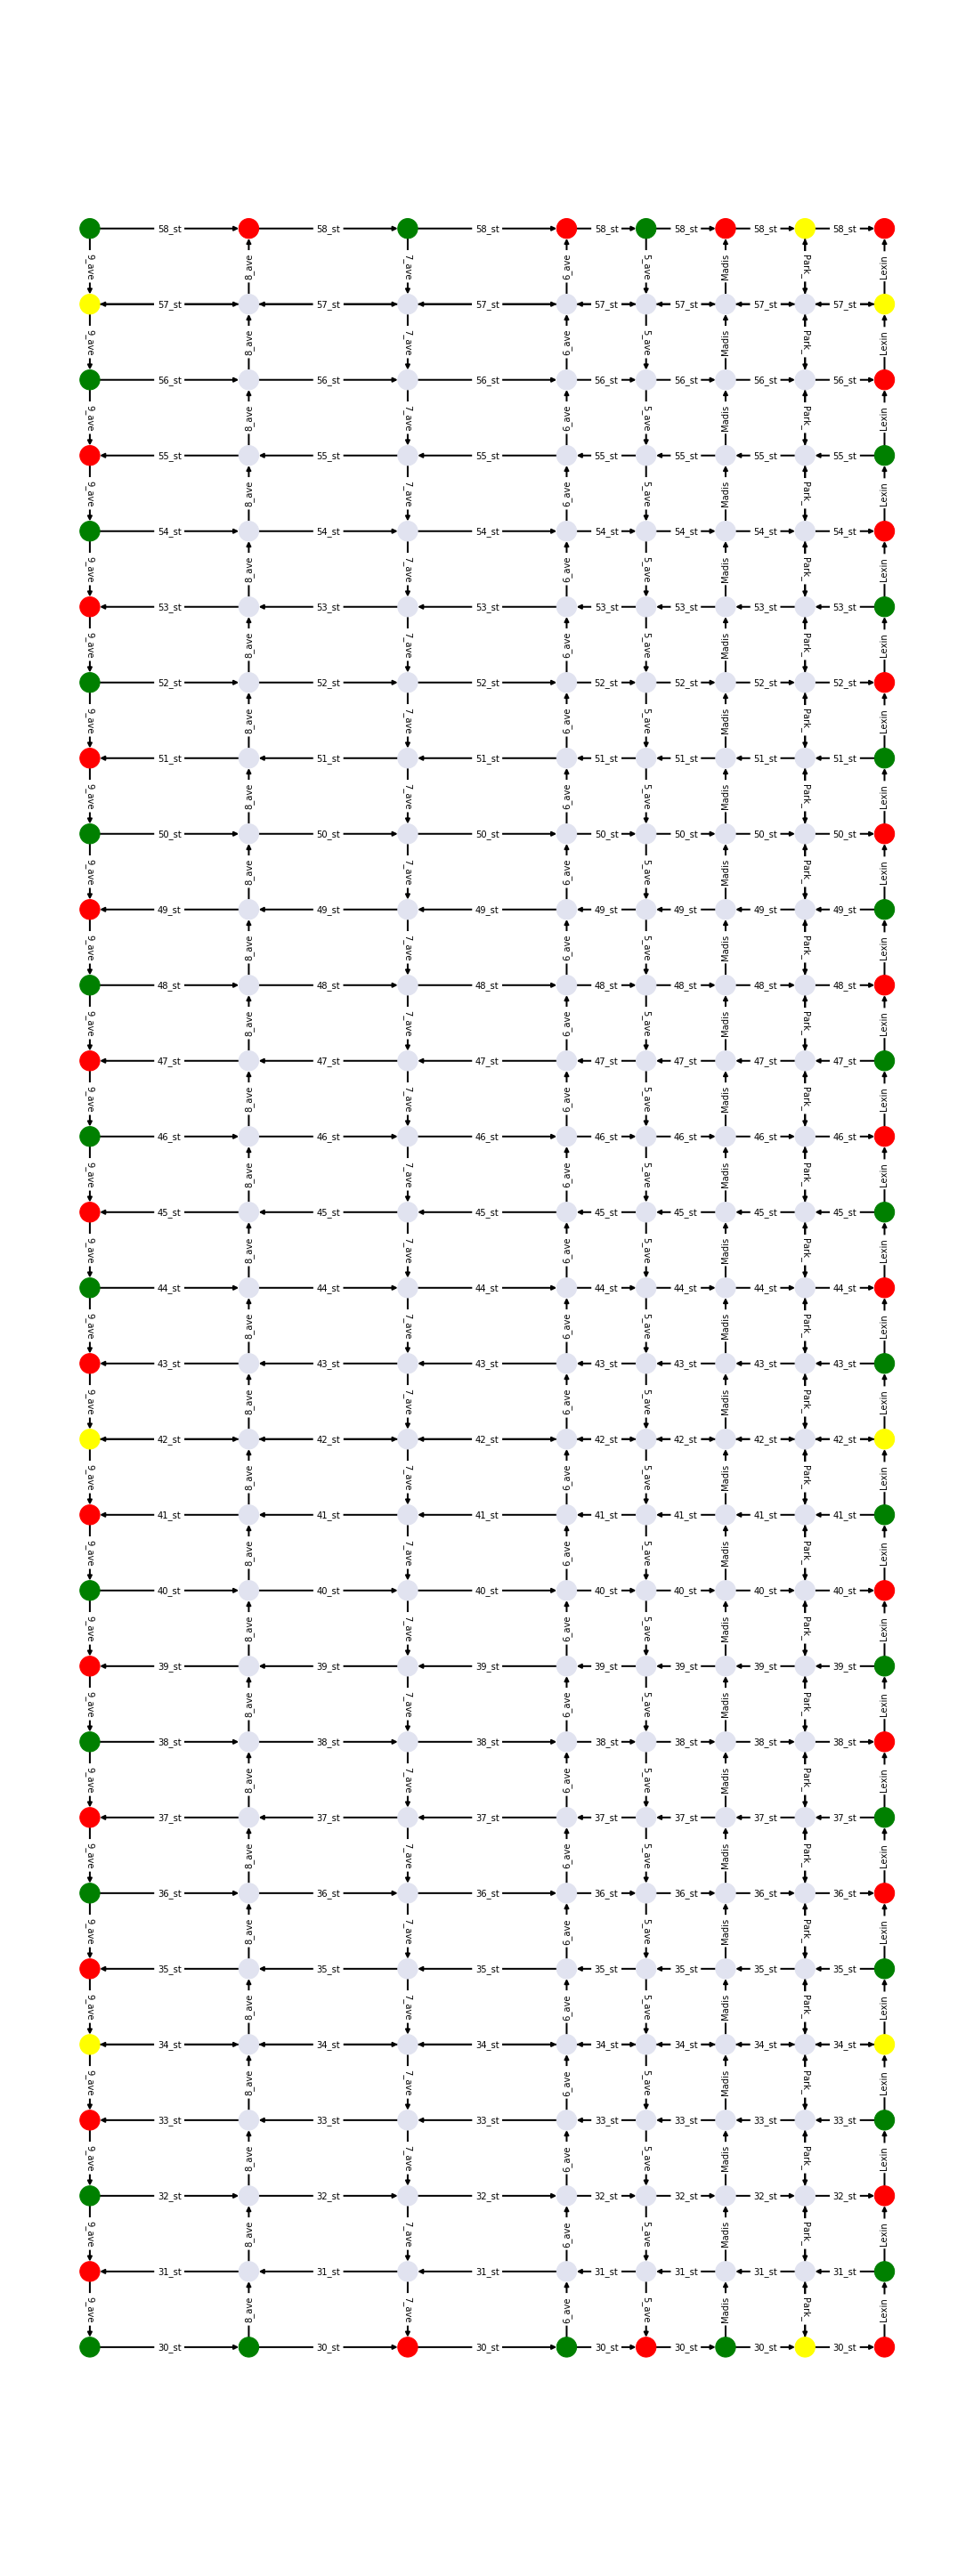

In [19]:
pos = nx.get_node_attributes(DG,'cartesian')
nodecol = nx.get_node_attributes(DG, 'color').values()
nodename = nx.get_node_attributes(DG, 'name')

plt.figure(figsize=(15,40)) 
nx.draw(DG, 
        pos, 
        width=2,
        node_color=nodecol,
        font_color='blue',
        node_size=500)
        #labels=nodename)
    
stnames = nx.get_edge_attributes(DG,"name")
for key in stnames:
    stnames[key] = stnames[key][:5]
    
nx.draw_networkx_edge_labels(DG,pos,edge_labels=stnames,font_color='black')

plt.show()

In [33]:
for i, n in enumerate(DG.nodes):
    print (n, DG.nodes[n])
    if i > 5: break

0 {'cartesian': (0, 0), 'name': '9_30', 'latitude': 40.750885, 'longitude': -73.998169, 'nodetype': 'source', 'color': 'green'}
1 {'cartesian': (0, 1), 'name': '9_31', 'latitude': 40.751518, 'longitude': -73.997705, 'nodetype': 'sink', 'color': 'red'}
2 {'cartesian': (0, 2), 'name': '9_32', 'latitude': 40.752151, 'longitude': -73.997242, 'nodetype': 'source', 'color': 'green'}
3 {'cartesian': (0, 3), 'name': '9_33', 'latitude': 40.752784, 'longitude': -73.996778, 'nodetype': 'sink', 'color': 'red'}
4 {'cartesian': (0, 4), 'name': '9_34', 'latitude': 40.753416, 'longitude': -73.996315, 'nodetype': 'source_sink', 'color': 'yellow'}
5 {'cartesian': (0, 5), 'name': '9_35', 'latitude': 40.754049, 'longitude': -73.995852, 'nodetype': 'sink', 'color': 'red'}
6 {'cartesian': (0, 6), 'name': '9_36', 'latitude': 40.754681, 'longitude': -73.995388, 'nodetype': 'source', 'color': 'green'}


In [32]:
for i, n in enumerate(DG.edges):
    print (n, DG.edges[n])
    if i > 5: break

(0, 29) {'direction': 'east', 'lanes': 2, 'name': '30_st'}
(1, 0) {'direction': 'south', 'lanes': 4, 'name': '9_ave'}
(2, 1) {'direction': 'south', 'lanes': 4, 'name': '9_ave'}
(2, 31) {'direction': 'east', 'lanes': 2, 'name': '32_st'}
(3, 2) {'direction': 'south', 'lanes': 4, 'name': '9_ave'}
(4, 3) {'direction': 'south', 'lanes': 4, 'name': '9_ave'}
(4, 33) {'direction': 'east', 'lanes': 2, 'name': '34_st'}
